# MIR replicates latent space

> Using Woodwell ring trial and CVAE to create mid-infrared spectra embeddings

In [127]:
#!pip install --upgrade lssm

In [128]:
# import lssm
# lssm.__version__


In [129]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Imports

In [130]:
from pathlib import Path
from functools import partial

import fastcore.all as fc

import pandas as pd
from sklearn.model_selection import train_test_split

from torcheval.metrics import MeanSquaredError
from torch.optim import lr_scheduler
from torch import optim, nn

import torch
import torch.nn.functional as F
from torch.nn import init


from lssm.loading import load_mirs_ring_trial, get_spectra_pair_idxs
from lssm.dataloaders import CrossSpectraDataset, get_dls
from lssm.callbacks import (MetricsCB, BatchSchedCB, BatchTransformCB,
                            DeviceCB, TrainCB, ProgressCB, Callback)
from lssm.transforms import SNVTfm
from lssm.visualization import plot_spectra
from lssm.learner import Learner
from lssm.models import CVAE, init_weights, GeneralRelu

## Data loading

In [131]:
fname = Path().home() / \
    'pro/data/woodwell-ringtrial/drive-download-20231013T123706Z-001/RT_STD_allMIRspectra_raw.csv'
#fname = './data/RT_STD_allMIRspectra_raw.csv'
df = load_mirs_ring_trial(fname)
X_names = [int(c) for c in df.columns[2:][::-1]]

In [132]:
df.head()


,organization,sample_id,650,652,654,656,658,660,662,664,...,3982,3984,3986,3988,3990,3992,3994,3996,3998,4000
0,Agrocares,RT_01,1.97644,1.97292,1.97015,1.96778,1.96656,1.96609,1.96656,1.96773,...,1.09917,1.09898,1.09877,1.09851,1.09827,1.09811,1.09797,1.09797,1.09797,1.09797
1,Agrocares,RT_02,2.48977,2.50440,2.51282,2.51789,2.51765,2.51403,2.50914,2.50330,...,1.24065,1.24042,1.24015,1.23977,1.23938,1.23896,1.23861,1.23861,1.23861,1.23861
2,Agrocares,RT_03,2.63074,2.63082,2.63692,2.64624,2.64827,2.64566,2.63292,2.61260,...,1.25036,1.24959,1.24877,1.24777,1.24679,1.24585,1.24505,1.24505,1.24505,1.24505
3,Agrocares,RT_04,2.27312,2.26257,2.25124,2.23949,2.23315,2.23026,2.22792,2.22598,...,1.15192,1.15176,1.15158,1.15132,1.15106,1.15080,1.15058,1.15058,1.15058,1.15058
4,Agrocares,RT_05,2.26744,2.25584,2.24658,2.23859,2.23159,2.22521,2.22157,2.22000,...,1.16109,1.16106,1.16102,1.16095,1.16086,1.16070,1.16056,1.16056,1.16056,1.16056


<Figure size 640x480 with 0 Axes>

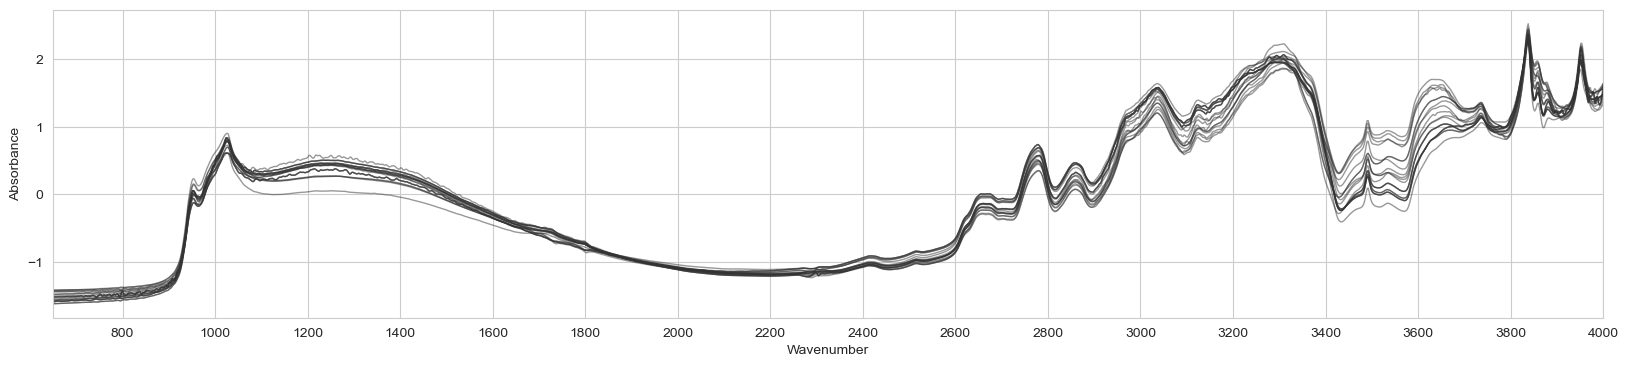

In [133]:
# Visualizing replicates (same soil with different spectrometers)
from lssm.preprocessing import SNV
get_replicates = lambda df, id: [y for x, y in get_spectra_pair_idxs(df) if x == id]

plot_spectra(SNV().fit_transform(
    df.iloc[get_replicates(df, 9), 2:].to_numpy()), X_names, alpha=0.5, sample=20)

In [134]:
pair_idxs_train, pair_idxs_valid = train_test_split(get_spectra_pair_idxs(df),
                                                    test_size=0.2, random_state=41)


In [135]:
train_ds, valid_ds = [CrossSpectraDataset(df, pair_idxs_train)
                      for pair_idxs in [pair_idxs_train, pair_idxs_valid]]

In [136]:
# Then PyTorch dataloaders
dls = get_dls(train_ds, valid_ds, bs=16)

first_batch = next(iter(dls.train))
print(f'First batch X dim: {first_batch[0].shape}')
print(f'First batch y dim: {first_batch[1].shape}')

First batch X dim: torch.Size([16, 1, 1676])
First batch y dim: torch.Size([16, 1, 1676])


<Figure size 640x480 with 0 Axes>

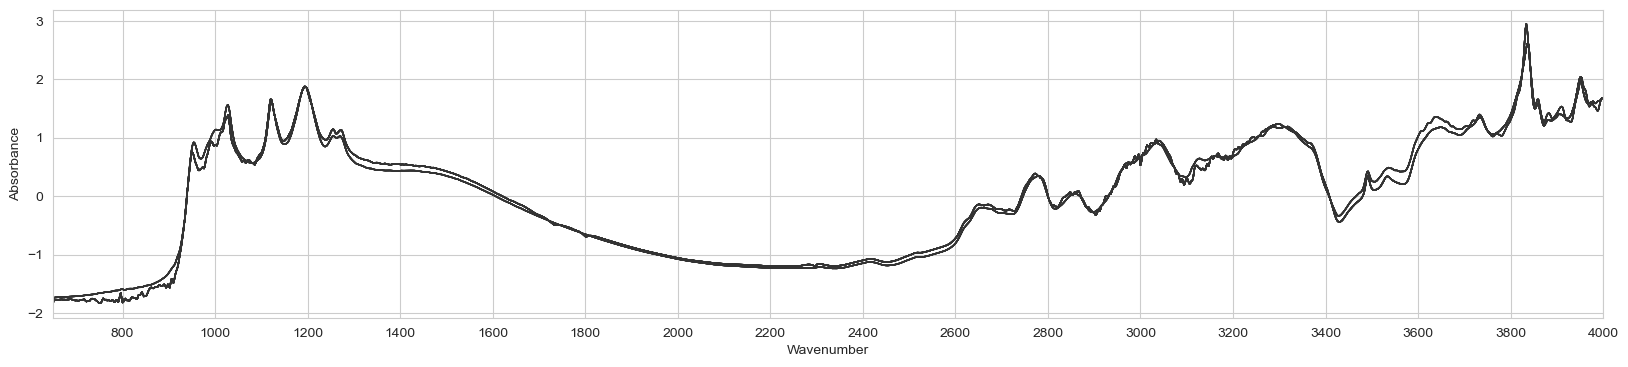

In [137]:
# Checking x, y pair as yielded by dataloader
idx = 1
t = torch.cat([first_batch[0][idx], first_batch[1][idx]]).numpy()
t = SNV().fit_transform(t)
plot_spectra(t, X_names, alpha=0.5)

## Training

In [138]:
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
iw = partial(init_weights, leaky=0.1)

In [139]:
n_wavenumbers = first_batch[0].shape[-1]
vae = CVAE(in_shape=n_wavenumbers)
input_reconstructed, _, _ = vae(first_batch[0]); input_reconstructed.shape

torch.Size([16, 1, 1676])

In [148]:
from lssm.callbacks import to_cpu
from torcheval.metrics import Mean
from copy import copy

class VAETrainCB(Callback):
    def predict(self, learn):
        learn.preds = learn.model(learn.batch[0])

    def get_loss(self, learn):
        y_hat, mu, logvar = learn.preds
        y = learn.batch[1]
        learn.loss = learn.loss_func(y_hat, y, mu, logvar)

    def backward(self, learn): learn.loss.backward()
    def step(self, learn): learn.opt.step()
    def zero_grad(self, learn): learn.opt.zero_grad()

In [141]:
class MetricsCB(Callback):
    def __init__(self, *ms, **metrics):
        for o in ms:
            metrics[type(o).__name__] = o
        self.metrics = metrics
        self.all_metrics = copy(metrics)
        self.all_metrics['loss'] = self.loss = Mean()

    def _log(self, d): print(d)
    def before_fit(self, learn): learn.metrics = self

    def before_epoch(self, learn): [o.reset()
                                    for o in self.all_metrics.values()]

    def after_epoch(self, learn):
        log = {k: f'{v.compute():.3f}' for k, v in self.all_metrics.items()}
        log['epoch'] = learn.epoch
        log['train'] = 'train' if learn.model.training else 'eval'
        self._log(log)

    def after_batch(self, learn):
        x, y, *_ = to_cpu(learn.batch)
        y_hat, y = [s.squeeze(1) for s in [learn.preds[0], y]]
        for m in self.metrics.values():
            # m.update(to_cpu(learn.preds[0]), y)
            m.update(to_cpu(y_hat), y)
        self.loss.update(to_cpu(learn.loss), weight=len(x))

In [142]:
# Loss Function
def loss_function(recon_x, x, mu, logvar):
    #criterion = nn.MSELoss()
    criterion = nn.HuberLoss()
    recon_loss = criterion(recon_x, x)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + KLD

In [145]:
# lr_find
lr = 1e-3
model = CVAE(in_shape=n_wavenumbers, 
             z_dim=2, nfs=(8, 16, 32, 64)).apply(iw)

metrics = MetricsCB(mse=MeanSquaredError())
_snv = BatchTransformCB(SNVTfm(is_VAE=True))
cbs = [DeviceCB(), _snv, VAETrainCB(), metrics, ProgressCB(plot=False)]
learn = Learner(model, dls, loss_function, lr=lr,
                cbs=cbs, opt_func=optim.AdamW)

In [149]:
lr = 1e-3
model = CVAE(in_shape=n_wavenumbers, 
             z_dim=2, nfs=(8, 16, 32, 64)).apply(iw)

xtra = [BatchSchedCB(sched)]
metrics = MetricsCB(mse=MeanSquaredError())
_snv = BatchTransformCB(SNVTfm(is_VAE=True))
cbs = [DeviceCB(device='cpu'), _snv, VAETrainCB(), metrics, ProgressCB(plot=False)]
learn = Learner(model, dls, loss_function, lr=lr,
                cbs=cbs+xtra, opt_func=optim.AdamW)

In [150]:
dls.valid

In [147]:
learn.fit(n_epochs=1)

torch.Size([16, 1, 1676])
torch.Size([16, 1, 1676])
torch.Size([16, 1, 1676])
torch.Size([16, 1, 1676])
torch.Size([16, 1, 1676])
torch.Size([16, 1, 1676])
torch.Size([16, 1, 1676])
torch.Size([16, 1, 1676])
torch.Size([16, 1, 1676])
torch.Size([16, 1, 1676])
torch.Size([16, 1, 1676])
torch.Size([16, 1, 1676])
torch.Size([16, 1, 1676])
torch.Size([16, 1, 1676])
torch.Size([16, 1, 1676])
torch.Size([16, 1, 1676])
torch.Size([16, 1, 1676])
torch.Size([16, 1, 1676])
torch.Size([16, 1, 1676])
torch.Size([16, 1, 1676])
torch.Size([16, 1, 1676])
torch.Size([16, 1, 1676])
torch.Size([16, 1, 1676])
torch.Size([16, 1, 1676])
torch.Size([16, 1, 1676])
torch.Size([16, 1, 1676])
torch.Size([16, 1, 1676])
torch.Size([16, 1, 1676])
torch.Size([16, 1, 1676])
torch.Size([16, 1, 1676])
torch.Size([16, 1, 1676])
torch.Size([16, 1, 1676])
torch.Size([16, 1, 1676])
torch.Size([16, 1, 1676])
torch.Size([16, 1, 1676])
torch.Size([16, 1, 1676])
torch.Size([16, 1, 1676])
torch.Size([16, 1, 1676])
torch.Size([

KeyboardInterrupt: 

In [80]:
learn.model.train(False);

In [90]:
x_recon, _, _ = learn.model(next(iter(learn.dls.train))[0][0].unsqueeze(dim=0))

In [ ]:
# what does train (true/false) do?

In [92]:
x_recon.shape

torch.Size([1, 1, 1676])

In [ ]:
# Checking x, y pair as yielded by dataloader
idx = 1
t = torch.cat([first_batch[0][idx], first_batch[1][idx]]).numpy()
t = SNV().fit_transform(t)
plot_spectra(t, X_names, alpha=0.5)

In [18]:
# @fc.patch
# def summary(self:Learner):
#     res = '|Module|Input|Output|Num params|\n|--|--|--|--|\n'
#     tot = 0
#     def _f(hook, mod, inp, outp):
#         nonlocal res,tot
#         nparms = sum(o.numel() for o in mod.parameters())
#         tot += nparms
#         res += f'|{type(mod).__name__}|{tuple(inp[0].shape)}|{tuple(outp.shape)}|{nparms}|\n'
#     with Hooks(self.model, _f) as hooks: self.fit(1, lr=1, train=False, cbs=SingleBatchCB())
#     print("Tot params: ", tot)
#     if fc.IN_NOTEBOOK:
#         from IPython.display import Markdown
#         return Markdown(res)
#     else: print(res)

In [47]:
# learn.lr_find()

In [ ]:
CVAE(1500)(torch.rand((1,1, 1500)))

In [50]:
model = CVAE(in_shape=1676, zdim=2, nfs=(8, 16, 32, 64, 128))
epochs = 1
lr = 5e-4

metrics = MetricsCB(mse=MeanSquaredError())

tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)

_snv = BatchTransformCB(SNVTfm())
xtra = [BatchSchedCB(sched)]
# cbs = [DeviceCB(device='cuda'), _snv, VAETrainCB(),
cbs = [DeviceCB(device='cpu'), _snv, VAETrainCB(),
       metrics, ProgressCB(plot=False)]

learn = Learner(model, dls, loss_function, lr=lr,
                cbs=cbs+xtra, opt_func=optim.AdamW)

learn.fit(epochs)


torch.Size([16, 26816, 1676])


RuntimeError: Given groups=1, weight of size [8, 1, 3], expected input[16, 26816, 1676] to have 1 channels, but got 26816 channels instead

In [194]:
idx = 0

<Figure size 640x480 with 0 Axes>

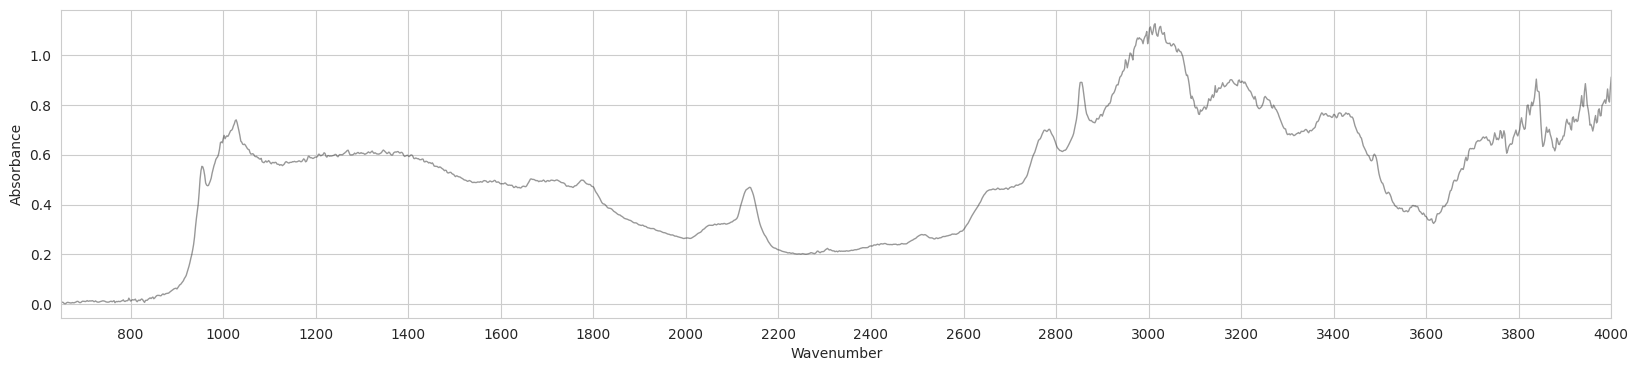

In [195]:
plot_spectra(first_batch[0].to(device='cuda')[
             idx].cpu(), X_names, alpha=0.5, sample=1)


In [212]:
learn.model.train(False)


In [65]:
first_batch[0][[0]].shape


torch.Size([1, 1, 1676])

In [ ]:
# with torch.no_grad(): t = to_cpu(model(xb.cuda()).float())


<Figure size 640x480 with 0 Axes>

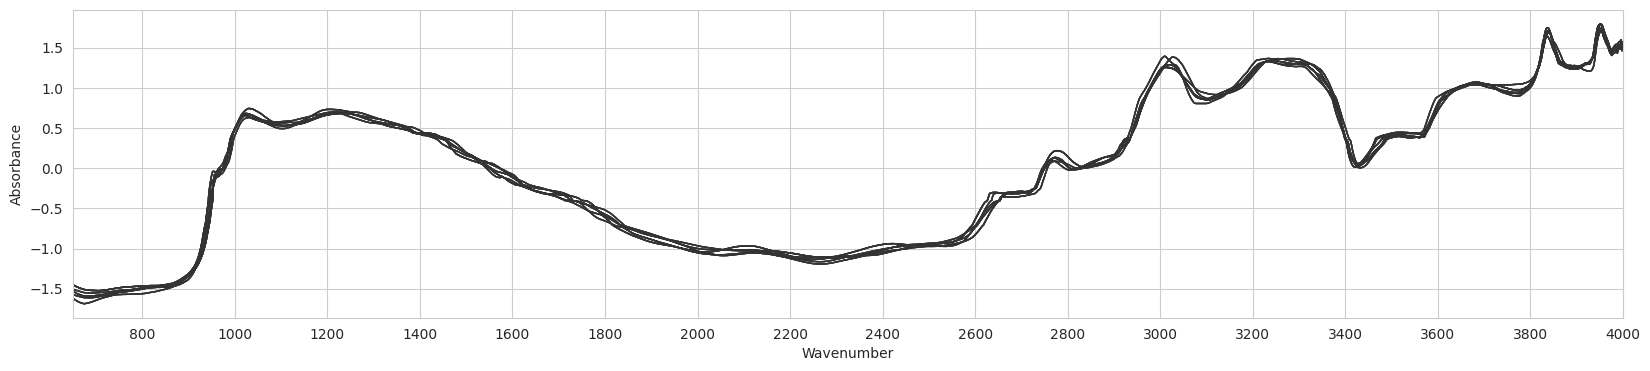

In [215]:
idx = 20
n_replicates = 5
replicates = []

for _ in range(n_replicates):
    replicates.append(learn.model(first_batch[0].to(
        device='cuda')[None, idx])[0].squeeze(0))

X_aug = torch.cat(replicates).squeeze(1).cpu().detach()
plot_spectra(X_aug, X_names, alpha=0.5)


In [328]:
X_recon = learn.model(learn.batch[0])[0]
idx = 4
plot_spectra(learn.batch[0][idx].squeeze(
    1).cpu(), X_names, alpha=0.5, sample=1)
plot_spectra(X_recon[idx].cpu().detach().numpy(), X_names, alpha=0.5, sample=1)
